In [3]:
# loading essential libraries #
import numpy as np              
import pandas as pd             
import librosa                  
import torch
import pandas as pd

In [6]:
#loading csv
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)



Train shape: (444, 2)
Test shape: (195, 1)


In [8]:
#data cleaning and preprocessing
print("\nMissing Values:")
print(train_df.isnull().sum())


Missing Values:
filename    0
label       0
dtype: int64


Visualizing Sample Audio: audio_1261.wav


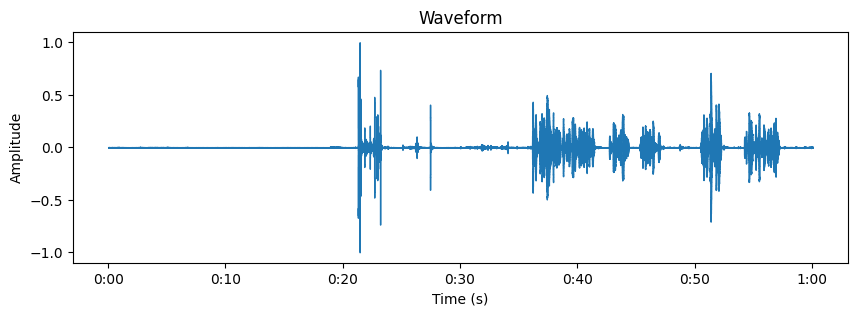

In [10]:
#Visualization
import librosa
import librosa.display
import matplotlib.pyplot as plt

sample_filename = train_df.iloc[0]['filename']
sample_path = "audios_train/" + sample_filename
print(f"Visualizing Sample Audio: {sample_filename}")
y, sr = librosa.load(sample_path, sr=None)
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


In [11]:
#Feature Extraction Pipeline
import librosa
import numpy as np

def extract_features(file_path):

    y, sr = librosa.load(file_path, sr=None)
    features = []

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.extend(np.mean(mfccs, axis=1))  
    features.extend(np.std(mfccs, axis=1))   
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.extend(np.mean(chroma, axis=1))
    features.extend(np.std(chroma, axis=1))
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features.extend(np.mean(contrast, axis=1))
    features.extend(np.std(contrast, axis=1))
    zcr = librosa.feature.zero_crossing_rate(y)
    features.append(np.mean(zcr))
    features.append(np.std(zcr))
    rms = librosa.feature.rms(y=y)
    features.append(np.mean(rms))
    features.append(np.std(rms))

    return features


In [12]:
#training set feature extraction
!pip install tqdm
from tqdm import tqdm
import os
#path
audio_folder = "audios_train/"

X = []
y = []

for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Extracting features"):
    file_path = os.path.join(audio_folder, row['filename'])  # Full path to the audio file
    features = extract_features(file_path)  # Extract audio features
    X.append(features)  # Add feature vector to dataset
    y.append(row['label'])  # Add label to target list

X = np.array(X)
y = np.array(y)

print("Feature extraction complete!")
print("X shape:", X.shape)
print("y shape:", y.shape)


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


Extracting features: 100%|███████████████████████████████████████████████████████████| 444/444 [01:54<00:00,  3.86it/s]

Feature extraction complete!
X shape: (444, 68)
y shape: (444,)


In [18]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Initialize and train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)


mse = mean_squared_error(y_val, y_pred)
pearson_corr, _ = pearsonr(y_val, y_pred)

print(f"Validation MSE: {mse:.4f}")  
print(f"Validation Pearson Correlation: {pearson_corr:.4f}")  


Validation MSE: 0.7845
Validation Pearson Correlation: 0.7040


In [17]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_val)

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

mse = mean_squared_error(y_val, xgb_pred)

pearson_corr, _ = pearsonr(y_val, xgb_pred)


print(f"[XGBoost] MSE: {mse:.4f}")
print(f"[XGBoost] Pearson Correlation: {pearson_corr:.4f}")


[XGBoost] MSE: 0.8376
[XGBoost] Pearson Correlation: 0.6314


In [20]:
#test feature extraction
# Path to the test audio folder
test_audio_folder = "audios_test/"

# Lists to store features and corresponding filenames
X_test = []
filenames = []

# Loop through each test audio file and extract features
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    file_path = os.path.join(test_audio_folder, row['filename'])
    features = extract_features(file_path)
    X_test.append(features)
    filenames.append(row['filename'])

# Convert features to NumPy array
X_test = np.array(X_test)
print("Test feature extraction complete. Shape:", X_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [00:50<00:00,  3.83it/s]

Test feature extraction complete. Shape: (195, 68)


In [21]:
#Generate Csv
# Make predictions using the trained Random Forest model
test_preds = model.predict(X_test)  

submission = test_df.copy()
submission['label'] = test_preds

submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")


Submission file saved as submission.csv
